In [1]:
# Activate Spark in our Colab notebook.
import os
spark_version = 'spark-3.2.2'

# spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.2.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.2.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3.2"

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 2s (120 kB/s)
Reading package lis

In [2]:
# Start a SparkSession
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MidtermProject").getOrCreate()

In [4]:
#import additional libraries
from pyspark import SparkFiles
from pyspark.sql import Row
from pyspark.sql.functions import split
from pyspark.sql.functions import split, col,substring,regexp_replace
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *

In [5]:
#read file into a spark dataframe
diabetes_df = spark.read.csv('diabetic_data.csv', sep=",", header=True, inferSchema=True)
diabetes_df.show()

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [6]:
#show the schema of the dataset
diabetes_df.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-

ETL Process

In [7]:
#drop weight, payor_code, medical speacialty
diabetes_df_dropped_col_3=diabetes_df.drop('weight','medical_specialty','payer_code')
diabetes_df_dropped_col_3.show(5)

+------------+-----------+---------------+------+-------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|gl

In [8]:
#replace question mark signs with Na
diabetes_df_w_nulls=diabetes_df_dropped_col_3.replace("?",None)
diabetes_df_w_nulls.show(5)

+------------+-----------+---------------+------+-------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|gl

In [9]:
#check if dataframe has been updated and can now contain null values.
nulls_dropped_diabetes_df = diabetes_df_w_nulls.na.drop("any")
nulls_dropped_diabetes_df.show(5)

+------------+-----------+---------------+------+-------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|gl

In [10]:
#print schema to check the number of columns and see if the columns have the option of becoming null
nulls_dropped_diabetes_df.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- 

### Break down the Master dataset into normalized tables.
# Patient
*   patient_nbr (PK)
*   age
*   gender
*   race
# Admission_type
*   admission_type_id (PK)
*   admission_name
# Admission source
*   admission_source_id (PK)
*   asmission_source_name
# Discharge Table
-discharge_disposition_id (PK)
-discharge_name
# Medication Table
-medication__id (PK)
-medication_type
# Patient_medication Table
-medication__id (PK)
-encounter_id (PK)
-change_in_dosage
# Diagnosis Table
-diagnosis_id
-diagnosis_type
# Encounter Table
-encounter_id (PK)
-patient_nbr (FK)
-num_lab_procedures
-num_procedures
-num_medications
-number_emergency
-number_outpatient
-number_inpatient
-time_in_hospital
-readmitted
-admission_type_id (FK)
-admission_source_id (FK)
-discharge_disposition_id (FK)
-diag_1(FK)
-diag_2(FK)
-diag_3(FK)
-number_diagnoses
-change
-A1Cresult
-max_glu_serum
-diabetesMed

In [11]:
#create a patient table with unique patient number to remove duplicates
def patient_tab(df):
  uniq_patient_number=df.drop_duplicates(subset = ["patient_nbr"])
  patient_table=uniq_patient_number[['patient_nbr','age','race','gender']]
  return patient_table

In [12]:
#call on the patient tab fundtion to see the patient table
patient_table=patient_tab(nulls_dropped_diabetes_df)
patient_table.show(5)

+-----------+-------+---------------+------+
|patient_nbr|    age|           race|gender|
+-----------+-------+---------------+------+
|        135|[50-60)|      Caucasian|Female|
|        378|[50-60)|      Caucasian|Female|
|        729|[80-90)|      Caucasian|Female|
|        774|[80-90)|      Caucasian|Female|
|        927|[30-40)|AfricanAmerican|Female|
+-----------+-------+---------------+------+
only showing top 5 rows



In [13]:
patient_table.write.csv('Patient_Table.csv')

AnalysisException: ignored

In [ ]:
#read in the admission type csv file 
admission_type=spark.read.csv('admission_type.csv',  sep=",", header=True)
admission_type.show()

In [ ]:
#read in the admission source csv file
admission_source=spark.read.csv('admission_source.csv', sep=",", header=True)
admission_source.show()

In [ ]:
#read in the discharge csv file
discharge_disposition=spark.read.csv('discharge_disposition.csv', sep=",", header=True)
discharge_disposition.show()

In [14]:
#Create Medication table
medication_id=np.arange(1,24)
medication_type=nulls_dropped_diabetes_df.columns[21:44]
medication=pd.DataFrame({"medication_id":medication_id, "medication_type":medication_type})
medication_df=spark.createDataFrame(medication)
medication_df.show(5)

+-------------+---------------+
|medication_id|medication_type|
+-------------+---------------+
|            1|      metformin|
|            2|    repaglinide|
|            3|    nateglinide|
|            4| chlorpropamide|
|            5|    glimepiride|
+-------------+---------------+
only showing top 5 rows



In [ ]:
#write medication to a cs file
medication_df.write.csv('Medication Table.csv')

In [16]:
#Read in ICD-9 Codes
icd_codes_df = spark.read.csv('ICD-9_Code_1998.csv', sep=",", header=True, inferSchema=True)
icd_codes_df.show(5)

+-------------------------------------+
|ICD TITLE & CODE CROSS REFERENCE FILE|
+-------------------------------------+
|                  Intestinal infec...|
|                         Cholera -001|
|                  Due to Vibrio ch...|
|                  Due to Vibrio ch...|
|                   Unspecified -001.9|
+-------------------------------------+
only showing top 5 rows



In [17]:
#Finish transforming diagnosis table by spliting columns on hyphen and star and creating new columns
diagnosis_code=icd_codes_df.withColumn("diagnosis_code",(split('ICD TITLE & CODE CROSS REFERENCE FILE', "-(?!.*-)|\s-[^\w\n]")[1])) \
.withColumn("diagnosis_type",(split('ICD TITLE & CODE CROSS REFERENCE FILE', "-(?!.*-)|\s-[^\w\n]")[0])).drop('ICD TITLE & CODE CROSS REFERENCE FILE')
diagnosis_code.show(5)

+--------------+--------------------+
|diagnosis_code|      diagnosis_type|
+--------------+--------------------+
|           009| Intestinal infec...|
|           001|            Cholera |
|         001.0| Due to Vibrio ch...|
|         001.1| Due to Vibrio ch...|
|         001.9|        Unspecified |
+--------------+--------------------+
only showing top 5 rows



In [18]:
#remove categories of codes from original dataset
#split the columns based on hyphen
diagnosis_code_split=diagnosis_code.withColumn("name",(split('diagnosis_type', "-(?!.*-)(?=.*[\d])")[1]))
diagnosis_code_split.show(5)

+--------------+--------------------+----+
|diagnosis_code|      diagnosis_type|name|
+--------------+--------------------+----+
|           009| Intestinal infec...| 001|
|           001|            Cholera |null|
|         001.0| Due to Vibrio ch...|null|
|         001.1| Due to Vibrio ch...|null|
|         001.9|        Unspecified |null|
+--------------+--------------------+----+
only showing top 5 rows



In [19]:
#retain columns that have null value for name as they did not split.
diagnosis_table=diagnosis_code_split.where(diagnosis_code_split.name.isNull()).drop('name')
diagnosis_table.show(5)

+--------------+--------------------+
|diagnosis_code|      diagnosis_type|
+--------------+--------------------+
|           001|            Cholera |
|         001.0| Due to Vibrio ch...|
|         001.1| Due to Vibrio ch...|
|         001.9|        Unspecified |
|           002|Typhoid and parat...|
+--------------+--------------------+
only showing top 5 rows



In [20]:
patient_medication_cols=nulls_dropped_diabetes_df.select('encounter_id', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
          'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
          'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone')

In [21]:
#change No to null to make it easier to drop
patient_medication_null=patient_medication_cols.replace('No', None)
patient_medication_null.show(5)

+------------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+
|encounter_id|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acetohexamide|glipizide|glyburide|tolbutamide|pioglitazone|rosiglitazone|acarbose|miglitol|troglitazone|tolazamide|examide|citoglipton|insulin|glyburide-metformin|glipizide-metformin|glimepiride-pioglitazone|metformin-rosiglitazone|metformin-pioglitazone|
+------------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+
|      

In [22]:
#create Patient medication table view
patient_medication_null.createOrReplaceTempView('patient_med')

In [23]:
#add all medication column values to one column
patient_med=spark.sql("""SELECT encounter_id,
          STACK(23, 'metformin', metformin,'repaglinide', repaglinide, 'nateglinide',nateglinide , 'chlorpropamide',chlorpropamide, 'glimepiride', glimepiride, 'acetohexamide', acetohexamide, 'glipizide',glipizide, 'glyburide',glyburide, 'tolbutamide',tolbutamide, 'pioglitazone',pioglitazone, 'rosiglitazone',rosiglitazone, 
                'acarbose',acarbose, 'miglitol',miglitol, 'troglitazone',troglitazone, 'tolazamide',tolazamide, 'examide',examide, 'citoglipton',citoglipton,
                'insulin',insulin, 'glyburide-metformin',`glyburide-metformin`, 'glipizide-metformin', `glipizide-metformin`, 'glimepiride-pioglitazone',`glimepiride-pioglitazone`, 'metformin-rosiglitazone',`metformin-rosiglitazone`,
                'metformin-pioglitazone',`metformin-pioglitazone`)
                as (type,change_in_dosage)FROM patient_med""")
patient_med.show()

+------------+-------------------+----------------+
|encounter_id|               type|change_in_dosage|
+------------+-------------------+----------------+
|      149190|          metformin|            null|
|      149190|        repaglinide|            null|
|      149190|        nateglinide|            null|
|      149190|     chlorpropamide|            null|
|      149190|        glimepiride|            null|
|      149190|      acetohexamide|            null|
|      149190|          glipizide|            null|
|      149190|          glyburide|            null|
|      149190|        tolbutamide|            null|
|      149190|       pioglitazone|            null|
|      149190|      rosiglitazone|            null|
|      149190|           acarbose|            null|
|      149190|           miglitol|            null|
|      149190|       troglitazone|            null|
|      149190|         tolazamide|            null|
|      149190|            examide|            null|
|      14919

In [24]:
#drop_null_values
patient_medication_drop_nulls=patient_med.dropna()
patient_medication_drop_nulls.show(5)

+------------+---------+----------------+
|encounter_id|     type|change_in_dosage|
+------------+---------+----------------+
|      149190|  insulin|              Up|
|       64410|glipizide|          Steady|
|      500364|  insulin|              Up|
|       16680|glipizide|          Steady|
|       16680|  insulin|          Steady|
+------------+---------+----------------+
only showing top 5 rows



In [25]:
#change the medication_type to medication id
patient_medication=patient_medication_drop_nulls.select('encounter_id','type', 'change_in_dosage').replace(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
          'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
          'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'],list(map(str, range(1,24))), 'type')
patient_medication_renamed=patient_medication.withColumnRenamed("type","medication_id")
patient_medication_renamed.show(5)

+------------+-------------+----------------+
|encounter_id|medication_id|change_in_dosage|
+------------+-------------+----------------+
|      149190|           18|              Up|
|       64410|            7|          Steady|
|      500364|           18|              Up|
|       16680|            7|          Steady|
|       16680|           18|          Steady|
+------------+-------------+----------------+
only showing top 5 rows



In [26]:
#write patient_medication_renamed to patient_medication_table
patient_medication_renamed.write.csv('Patient_medication_table')

AnalysisException: ignored

In [27]:
#create the encounter table
encounter_table=nulls_dropped_diabetes_df.select('encounter_id', 'patient_nbr', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'readmitted')
encounter_table.show(5)

+------------+-----------+-------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+------+-----------+----------+
|encounter_id|patient_nbr|    age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|change|diabetesMed|readmitted|
+------------+-----------+-------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+------+-----------+----------+
|      149190|   55629189|[10-20)|                1|                     

In [ ]:
#write encounter_table to csv
encounter_table.write.csv('Encounter Table')


# **PySpark SQL Query**


In [29]:
#Create Temporary Views
patient_medication_renamed.createOrReplaceTempView('pm')
diagnosis_table.createOrReplaceTempView('diagnosis_table')
medication_df.createOrReplaceTempView('medication_table')
patient_table.createOrReplaceTempView('patients')
encounter_table.createOrReplaceTempView('encounter_table')

Question #1:  Which medication type had the least percentage of patients that were readmitted in less than 30 days?
*   Answer:  tolbutamide



In [30]:
#Build query for question # 1
question1= """(SELECT m.medication_type, (Round((SUM(CASE WHEN e.readmitted = '<30' THEN 1 ELSE 0 END)/count(e.patient_nbr))*100,2)) as percentage_of_readmitted_patients
FROM encounter_table AS e
JOIN pm
ON (pm.encounter_id = e.encounter_id)
JOIN medication_table AS m
ON (m.medication_id = pm.medication_id)
GROUP by m.medication_type
Order by percentage_of_readmitted_patients)"""

#Start Timer to time how long it takes to run the query for question # 1
start_time = time.time()
q1_df=spark.sql(question1)
q1_df.show()
#End Timer
print("--- %s seconds ---" % (time.time() - start_time))


+--------------------+---------------------------------+
|     medication_type|percentage_of_readmitted_patients|
+--------------------+---------------------------------+
|glimepiride-piogl...|                              0.0|
|       acetohexamide|                              0.0|
|metformin-pioglit...|                              0.0|
|        troglitazone|                              0.0|
|         tolbutamide|                             4.55|
|      chlorpropamide|                             6.02|
| glipizide-metformin|                             7.69|
|          tolazamide|                             8.11|
|            acarbose|                             9.03|
|           metformin|                             9.79|
|         glimepiride|                            10.23|
|       rosiglitazone|                            10.48|
|        pioglitazone|                            10.59|
| glyburide-metformin|                            10.61|
|           glyburide|         

[Text(0.5, 1.0, 'Percentage of Readmitted Patients based on Medication Type')]

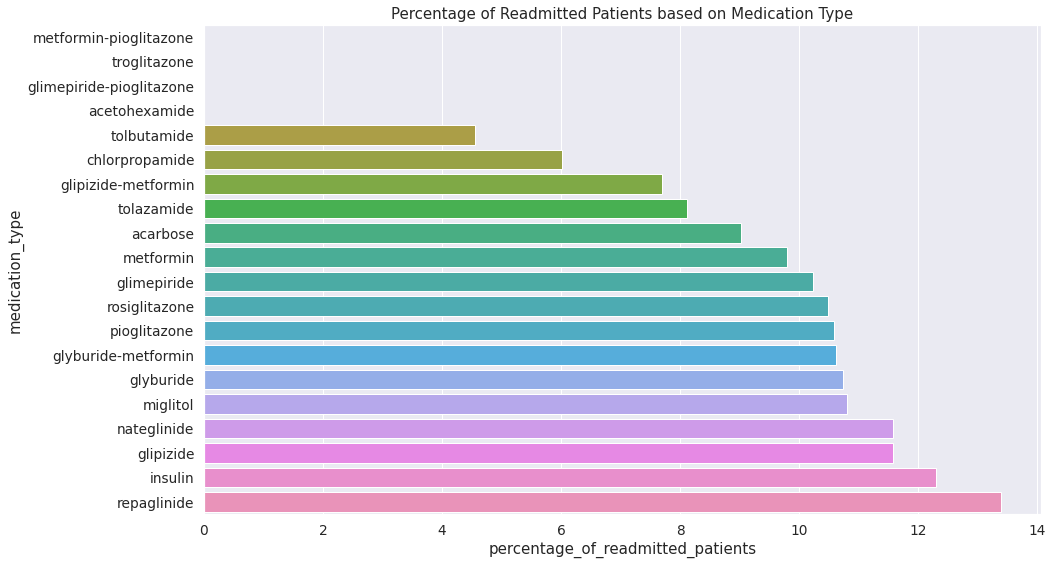

In [31]:
#change spark dataframe to Pandas for visualization
fig=plt.figure(figsize=(15,9))
question1_df=q1_df.toPandas()
sns.set_style("darkgrid")
sns.set(font_scale=1.25)
sns.barplot(data=question1_df, y="medication_type",x="percentage_of_readmitted_patients"
            ).set(title='Percentage of Readmitted Patients based on Medication Type')


Question #2:  Which Age group on diabetes medication spent the least amount of time in the hospital?


*   Answer:  0-10 age group




In [32]:
#Build query for question # 2
question2="""(SELECT p.age, ROUND((AVG(e.time_in_hospital)),2) as avg_time_in_hospital
FROM encounter_table AS e
JOIN patients AS p
ON (p.patient_nbr = e.patient_nbr)
WHERE e.diabetesMed == 'Yes'
GROUP BY p.age
ORDER BY ROUND((AVG(e.time_in_hospital)),2) ASC )"""

#Start Timer to time how long it takes to run the query for question # 1
start_time = time.time()
q2_df=spark.sql(question2)
q2_df.show()
#End Timer
print("--- %s seconds ---" % (time.time() - start_time))


+--------+--------------------+
|     age|avg_time_in_hospital|
+--------+--------------------+
|  [0-10)|                2.96|
| [10-20)|                3.71|
| [20-30)|                3.75|
| [30-40)|                3.98|
| [40-50)|                4.19|
| [50-60)|                4.24|
| [60-70)|                 4.5|
| [70-80)|                4.71|
| [80-90)|                4.93|
|[90-100)|                4.97|
+--------+--------------------+

--- 4.208569765090942 seconds ---


[Text(0.5, 1.0, 'Average time in hospital based on age')]

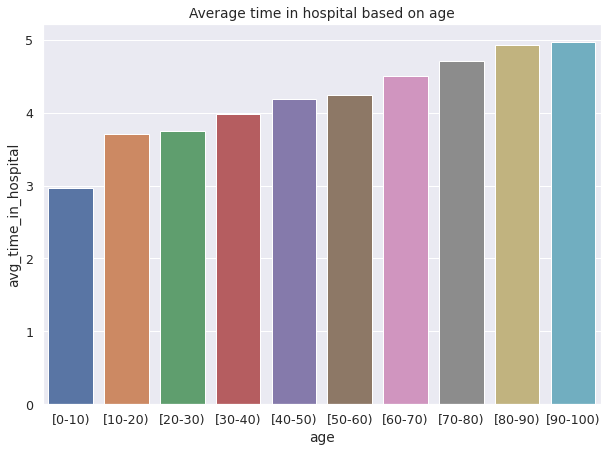

In [33]:
fig2=plt.figure(figsize=(10,7))
question2_df=q2_df.toPandas()
sns.set_style("darkgrid")
sns.set(font_scale=1.15)
sns.barplot(data=question2_df, x='age', y='avg_time_in_hospital').set(title="Average time in hospital based on age")

Question #3: Which Diabetes diagnosis group have the highest number of diagnosis based on gender


*   Anwser:  Diabetes meliltus diagnosis have the highest number of Diabetes diagnosis for both male and female.



In [34]:
#Build query for question # 3
question3 = """(SELECT p.gender, d.diagnosis_type, COUNT(d.diagnosis_type) as count,
RANK ()OVER(ORDER BY COUNT(d.diagnosis_type) DESC) as Rank
FROM encounter_table AS e
JOIN diagnosis_table AS d
ON (e.diag_1 = d.diagnosis_code OR e.diag_2 = d.diagnosis_code OR e.diag_3 = d.diagnosis_code)
JOIN patients AS p
ON (e.patient_nbr = p.patient_nbr)
GROUP BY p.gender, d.diagnosis_type
limit 10)"""

#Start Timer to time how long it takes to run the query for question # 3
start_time = time.time()

#Run query
q3_df=spark.sql(question3)
q3_df.show()
#Stop the timer and sub
print("--- %s seconds ---" % (time.time() - start_time))

+------+--------------------+-----+----+
|gender|      diagnosis_type|count|Rank|
+------+--------------------+-----+----+
|Female|      Heart failure | 9363|   1|
|Female|  Diabetes mellitus | 9227|   2|
|  Male|      Heart failure | 7752|   3|
|  Male|  Diabetes mellitus | 7584|   4|
|Female|Disorders of flui...| 7301|   5|
|  Male|Other forms of ch...| 6993|   6|
|Female|Essential hyperte...| 6845|   7|
|Female|Cardiac dysrhythm...| 5379|   8|
|  Male|Cardiac dysrhythm...| 5374|   9|
|  Male|Disorders of flui...| 5302|  10|
+------+--------------------+-----+----+

--- 11.749018907546997 seconds ---


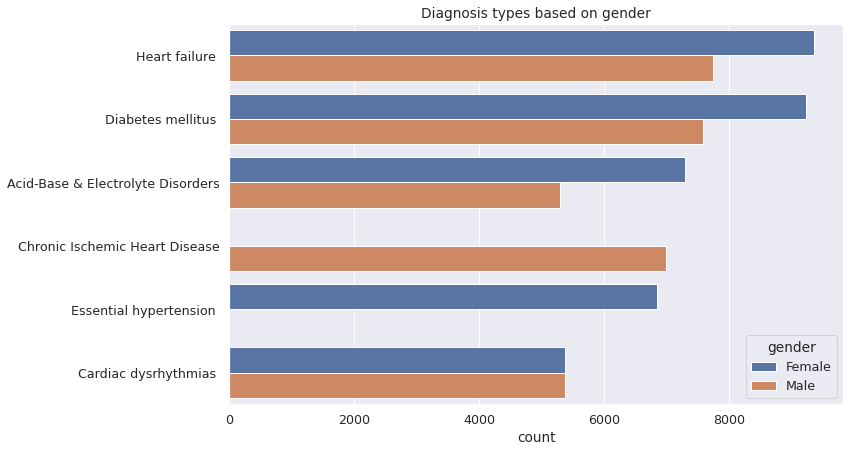

In [35]:
fig3=plt.figure(figsize=(11,7))
question3_df=q3_df.toPandas()
question3_df['diagnosis_type']=question3_df['diagnosis_type'].replace({'Disorders of fluid, electrolyte, and acid-base balance ': 'Acid-Base & Electrolyte Disorders',
                                       'Other forms of chronic ischemic heart disease ':'Chronic Ischemic Heart Disease'})
sns.set_style("darkgrid")
ques3=sns.barplot(data=question3_df, y='diagnosis_type',x='count', hue='gender').set(title="Diagnosis types based on gender", ylabel=None)


Question #4: Which age group and race had the highest number of diagnosis and readmitted within 30 days?


*   Answer:  70-80 Caucasian had the highest number of diagnosis and were readmitted within 30 days



In [36]:
#Build query for question # 4
question4 = """(SELECT p.age, p.race, COUNT(d.diagnosis_type) as count_of_diagnosis,
RANK() OVER(ORDER BY COUNT(d.diagnosis_type) DESC)as Rank 
FROM encounter_table AS e
JOIN diagnosis_table AS d
ON (e.diag_1 = d.diagnosis_code OR e.diag_2 = d.diagnosis_code OR e.diag_3 = d.diagnosis_code)
JOIN patients AS p
ON (e.patient_nbr = p.patient_nbr)
WHERE e.readmitted = '<30'
GROUP BY p.age, p.race
limit 20)"""
#Start Timer to time how long it takes to run the query for question # 3
start_time = time.time()
q4_df=spark.sql(question4)
q4_df.show()
#stop timer
print("--- %s seconds ---" % (time.time() - start_time))

+--------+---------------+------------------+----+
|     age|           race|count_of_diagnosis|Rank|
+--------+---------------+------------------+----+
| [70-80)|      Caucasian|              6309|   1|
| [60-70)|      Caucasian|              4685|   2|
| [80-90)|      Caucasian|              4442|   3|
| [50-60)|      Caucasian|              2934|   4|
| [40-50)|      Caucasian|              1577|   5|
| [60-70)|AfricanAmerican|              1240|   6|
| [70-80)|AfricanAmerican|              1158|   7|
| [50-60)|AfricanAmerican|               982|   8|
| [40-50)|AfricanAmerican|               848|   9|
|[90-100)|      Caucasian|               569|  10|
| [30-40)|      Caucasian|               549|  11|
| [80-90)|AfricanAmerican|               514|  12|
| [30-40)|AfricanAmerican|               310|  13|
| [20-30)|      Caucasian|               272|  14|
| [20-30)|AfricanAmerican|               159|  15|
| [60-70)|       Hispanic|               140|  16|
| [70-80)|       Hispanic|     

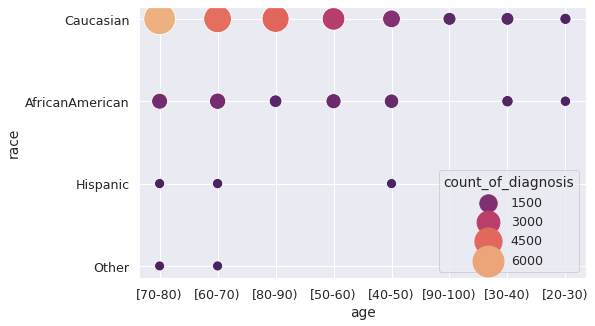

In [37]:
fig3=plt.figure(figsize=(8,5))
question4_df=q4_df.toPandas()

sns.set_style("darkgrid")
q4_fig=sns.scatterplot(data=question4_df, x = "age", y = "race", size = "count_of_diagnosis", 
                       hue="count_of_diagnosis",palette="flare_r", sizes=(100, 1000))
q4_fig

In [38]:
question4_df.count()

age                   20
race                  20
count_of_diagnosis    20
Rank                  20
dtype: int64

# **Parquet Demonstration**

In [39]:
#Write data of each data frame in parquet format
diagnosis_table.write.parquet('parquet_diagnosis_table', mode='overwrite')
patient_medication.write.parquet('parquet_pm', mode='overwrite')
medication_df.write.parquet('parquet_medication_table', mode='overwrite')
patient_table.write.parquet('parquet_patients', mode='overwrite')
encounter_table.write.parquet('parquet_encounter_table', mode='overwrite')

In [40]:
#Read in the newly parquet formated data to new dataframes
p_diagnosis_df=spark.read.parquet('parquet_diagnosis_table')
p_patient_medication_df=spark.read.parquet('parquet_pm')
p_medication_df=spark.read.parquet('parquet_medication_table')
p_patients_df=spark.read.parquet('parquet_patients')
p_encounter_df=spark.read.parquet('parquet_encounter_table')

In [41]:
#Convert each parquet formatted data frame into a new view
p_diagnosis_df.createOrReplaceTempView('p_diagnosis')
p_patient_medication_df.createOrReplaceTempView('p_patient_medications')
p_medication_df.createOrReplaceTempView('p_medications')
p_patients_df.createOrReplaceTempView('p_patients')
p_encounter_df.createOrReplaceTempView('p_encounters')

In [42]:
#Build updated queries with parquet temp views
question1 = """(SELECT m.medication_type, (Round((SUM(CASE WHEN e.readmitted = '<30' THEN 1 ELSE 0 END)/count(e.patient_nbr))*100,2)) as percentage_of_readmitted_patients
FROM p_encounters AS e
JOIN p_patient_medications AS pm
ON (pm.encounter_id = e.encounter_id)
JOIN p_medications AS m
ON (m.medication_id = pm.type)
GROUP by m.medication_type
Order by percentage_of_readmitted_patients)"""

question2 = """(SELECT p.age, ROUND((AVG(e.time_in_hospital)),2)
FROM p_encounters AS e
JOIN p_patients AS p
ON (p.patient_nbr = e.patient_nbr)
WHERE e.diabetesMed == 'Yes'
GROUP BY p.age
ORDER BY ROUND((AVG(e.time_in_hospital)),2) ASC)"""

question3 = """(SELECT p.gender, d.diagnosis_type, COUNT(d.diagnosis_type),
RANK ()OVER(ORDER BY COUNT(d.diagnosis_type) DESC) 
FROM p_encounters AS e
JOIN p_diagnosis AS d
ON (e.diag_1 = d.diagnosis_code OR e.diag_2 = d.diagnosis_code OR e.diag_3 = d.diagnosis_code)
JOIN p_patients AS p
ON (e.patient_nbr = p.patient_nbr)
GROUP BY p.gender, d.diagnosis_type)"""

question4 = """(SELECT p.age, p.race, COUNT(d.diagnosis_type),
RANK() OVER(ORDER BY COUNT(d.diagnosis_type) DESC) 
FROM p_encounters AS e
JOIN p_diagnosis AS d
ON (e.diag_1 = d.diagnosis_code OR e.diag_2 = d.diagnosis_code OR e.diag_3 = d.diagnosis_code)
JOIN p_patients AS p
ON (e.patient_nbr = p.patient_nbr)
WHERE e.readmitted = '<30'
GROUP BY p.age, p.race)"""

In [43]:
#Run queries on parquet views
#Start Timer to time how long it takes to run the query for question 1
start_time = time.time()

#Run query for question # 1
spark.sql(question1).show()

#End Timer
print("--- %s seconds ---" % (time.time() - start_time))

+--------------------+---------------------------------+
|     medication_type|percentage_of_readmitted_patients|
+--------------------+---------------------------------+
|metformin-pioglit...|                              0.0|
|glimepiride-piogl...|                              0.0|
|        troglitazone|                              0.0|
|       acetohexamide|                              0.0|
|         tolbutamide|                             4.55|
|      chlorpropamide|                             6.02|
| glipizide-metformin|                             7.69|
|          tolazamide|                             8.11|
|            acarbose|                             9.03|
|           metformin|                             9.79|
|         glimepiride|                            10.23|
|       rosiglitazone|                            10.48|
|        pioglitazone|                            10.59|
| glyburide-metformin|                            10.61|
|           glyburide|         

In [44]:
#Reset and Start Timer to time how long it takes to run the query for question 2
start_time = time.time()

#Run query for question # 2
spark.sql(question2).show()

#End Timer
print("--- %s seconds ---" % (time.time() - start_time))

+--------+-------------------------------+
|     age|round(avg(time_in_hospital), 2)|
+--------+-------------------------------+
|  [0-10)|                           2.96|
| [10-20)|                           3.71|
| [20-30)|                           3.75|
| [30-40)|                           3.98|
| [40-50)|                           4.19|
| [50-60)|                           4.24|
| [60-70)|                            4.5|
| [70-80)|                           4.71|
| [80-90)|                           4.93|
|[90-100)|                           4.97|
+--------+-------------------------------+

--- 0.8145730495452881 seconds ---


In [45]:
#Reset and Start Timer to time how long it takes to run the query for question 3
start_time = time.time()

#Run query for question # 3
spark.sql(question3).show()

#End Timer
print("--- %s seconds ---" % (time.time() - start_time))

+------+--------------------+---------------------+-------------------------------------------------------------------------------------------------------------+
|gender|      diagnosis_type|count(diagnosis_type)|RANK() OVER (ORDER BY count(diagnosis_type) DESC NULLS LAST ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)|
+------+--------------------+---------------------+-------------------------------------------------------------------------------------------------------------+
|Female|      Heart failure |                 9363|                                                                                                            1|
|Female|  Diabetes mellitus |                 9227|                                                                                                            2|
|  Male|      Heart failure |                 7752|                                                                                                            3|
|  Male|  Diabetes mellitus 

In [46]:
#Reset and Start Timer to time how long it takes to run the query for question 4
start_time = time.time()

#Run query for question # 4
spark.sql(question4).show()

#End Timer
print("--- %s seconds ---" % (time.time() - start_time))

+--------+---------------+---------------------+-------------------------------------------------------------------------------------------------------------+
|     age|           race|count(diagnosis_type)|RANK() OVER (ORDER BY count(diagnosis_type) DESC NULLS LAST ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)|
+--------+---------------+---------------------+-------------------------------------------------------------------------------------------------------------+
| [70-80)|      Caucasian|                 6309|                                                                                                            1|
| [60-70)|      Caucasian|                 4685|                                                                                                            2|
| [80-90)|      Caucasian|                 4442|                                                                                                            3|
| [50-60)|      Caucasian|                 293

#Caching Demonstration #

*   Rerun previous queries with views cached



In [47]:
#Cache parquet views
spark.sql("cache table p_diagnosis")
spark.sql("cache table p_patient_medications")
spark.sql("cache table p_medications")
spark.sql("cache table p_patients")
spark.sql("cache table p_encounters")


DataFrame[]

In [48]:
#Run queries on parquet views
#Reset and Start Timer to time how long it takes to run the query for question 1
start_time = time.time()

#Run query for question # 1
spark.sql(question1).show()

#End Timer
print("--- %s seconds ---" % (time.time() - start_time))

+--------------------+---------------------------------+
|     medication_type|percentage_of_readmitted_patients|
+--------------------+---------------------------------+
|metformin-pioglit...|                              0.0|
|glimepiride-piogl...|                              0.0|
|        troglitazone|                              0.0|
|       acetohexamide|                              0.0|
|         tolbutamide|                             4.55|
|      chlorpropamide|                             6.02|
| glipizide-metformin|                             7.69|
|          tolazamide|                             8.11|
|            acarbose|                             9.03|
|           metformin|                             9.79|
|         glimepiride|                            10.23|
|       rosiglitazone|                            10.48|
|        pioglitazone|                            10.59|
| glyburide-metformin|                            10.61|
|           glyburide|         

In [49]:
#Reset and Start Timer to time how long it takes to run the query for question 2
start_time = time.time()

#Run query for question # 2
spark.sql(question2).show()

#End Timer
print("--- %s seconds ---" % (time.time() - start_time))

+--------+-------------------------------+
|     age|round(avg(time_in_hospital), 2)|
+--------+-------------------------------+
|  [0-10)|                           2.96|
| [10-20)|                           3.71|
| [20-30)|                           3.75|
| [30-40)|                           3.98|
| [40-50)|                           4.19|
| [50-60)|                           4.24|
| [60-70)|                            4.5|
| [70-80)|                           4.71|
| [80-90)|                           4.93|
|[90-100)|                           4.97|
+--------+-------------------------------+

--- 0.5284032821655273 seconds ---


In [50]:
#Reset and Start Timer to time how long it takes to run the query for question 3
start_time = time.time()

#Run query for question # 3
spark.sql(question3).show()

#End Timer
print("--- %s seconds ---" % (time.time() - start_time))

+------+--------------------+---------------------+-------------------------------------------------------------------------------------------------------------+
|gender|      diagnosis_type|count(diagnosis_type)|RANK() OVER (ORDER BY count(diagnosis_type) DESC NULLS LAST ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)|
+------+--------------------+---------------------+-------------------------------------------------------------------------------------------------------------+
|Female|      Heart failure |                 9363|                                                                                                            1|
|Female|  Diabetes mellitus |                 9227|                                                                                                            2|
|  Male|      Heart failure |                 7752|                                                                                                            3|
|  Male|  Diabetes mellitus 

In [51]:
#Reset and Start Timer to time how long it takes to run the query for question 4
start_time = time.time()

#Run query for question # 4
spark.sql(question4).show()

#End Timer
print("--- %s seconds ---" % (time.time() - start_time))

+--------+---------------+---------------------+-------------------------------------------------------------------------------------------------------------+
|     age|           race|count(diagnosis_type)|RANK() OVER (ORDER BY count(diagnosis_type) DESC NULLS LAST ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)|
+--------+---------------+---------------------+-------------------------------------------------------------------------------------------------------------+
| [70-80)|      Caucasian|                 6309|                                                                                                            1|
| [60-70)|      Caucasian|                 4685|                                                                                                            2|
| [80-90)|      Caucasian|                 4442|                                                                                                            3|
| [50-60)|      Caucasian|                 293

# **Assertion Tests**

In [52]:
# Install pytest and pytest-sugar to make our output look nice.
!pip install -q pytest pytest-sugar

In [53]:
# Create and navigate to the tests directory.
from pathlib import Path
if Path.cwd().name != 'tests':
    %mkdir tests
    %cd tests
# Show the current working directory. 
%pwd

mkdir: cannot create directory ‘tests’: File exists
/content/tests


'/content/tests'

In [54]:
# Create a  __init__.py file that will contain that will be used to run our functions. 
# This file will be stored in our pwd (/content/tests)
%%file __init__.py
pass

Overwriting __init__.py


In [62]:
# Create a diabetic_data.py file that will contain the import_data function.
# This file will be stored in our pwd (/content/tests).
%%file diabetic_data.py

# Import findspark() and initialize.
import findspark
findspark.init()

import numpy as np


# Import other dependencies.
from pyspark import SparkFiles
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark_Diabetic_Data").getOrCreate()

# Create the import_data function.
def import_data():
    df = spark.read.csv("diabetic_data.csv", sep=",", header=True, inferSchema=True)
    df.createOrReplaceTempView('diabetic_data')
    
    return df

Overwriting diabetic_data.py


In [69]:
# Create a test_bank_data.py file that will contain the the test functions.
# This file will be stored in our pwd (/content/tdd).

%%file test_diabetic_data.py

import pandas as pd

from diabetic_data import import_data

#assert statement definitions
# asserting number of rows in master dataset
def test_row_count_before_transform():
    df = import_data()
    assert df.count() == 101766

#asserting #of columns in master dataset
def test_column_count_before_transform():
    df = import_data()
    assert len(df.columns) == 50

# asserting number of columns after removing 3 columns with missing values
def test_column_count_after_transform():
    df = import_data()
    df = df.drop('weight','medical_specialty','payer_code')
    assert len(df.columns) == 47

# asserting number of medication type values after pivoting from master dataset
def test_column_count_of_medication():
    df = import_data()
    df2 = pd.read_csv("Medication Table.csv")
    assert len(df.columns[24:47]) == len(df2)


Overwriting test_diabetic_data.py


In [68]:
!python -m pytest test_diabetic_data.py

Test session starts (platform: linux, Python 3.7.14, pytest 3.6.4, pytest-sugar 0.9.5)
rootdir: /content/tests, inifile:
plugins: typeguard-2.7.1, sugar-0.9.5

 test_diabetic_data.py ✓✓✓✓                                      100% ██████████

Results (15.84s):
       4 passed
